<a href="https://colab.research.google.com/github/splAcharya/Extractive_Text_Summarization/blob/main/ExTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive Text Summarization Of Wikipedia Articles

## Install Packages (if needed)

In [1]:
#gensim
!pip install --upgrade gensim

#rouge scorer
!pip install rouge-score

     |████████████████████████████████| 24.1 MB 26.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Import Required Libraries

In [2]:
import time
import re
import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
sw_set = set(stopwords.words("english"))

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import Phrases

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as LSA, LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from copy import deepcopy
from rouge_score import rouge_scorer
import pandas as pd
from collections import Counter, defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Number of Cores: 2


## Function to Webscrape Wikipedia Article

In [3]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/Hurricane_Irene_(2005)"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [4]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article

In [5]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/Hurricane_Irene_(2005)")
article_st, pp_article_st = preprocess_article(article_text)
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [6]:
pp_string = (" ").join(pp_article_st)

In [7]:
article_st[0]

'hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.'

In [8]:
pp_article_st[0:5]

['hurricane irene long lived cape verde hurricane 2005 atlantic hurricane season',
 'storm formed near cape verde august 4 crossed atlantic turning northward around bermuda absorbed extratropical cyclone situated southeast newfoundland',
 'irene proved difficult storm forecast due oscillation strength',
 'almost dissipating august 10 irene peaked category 2 hurricane august 16 irene persisted 14 day tropical system longest duration storm 2005 season',
 'ninth named storm fourth hurricane record breaking season']

In [9]:
article_text

'Hurricane Irene was a long-lived Cape Verde hurricane during the 2005 Atlantic hurricane season. The storm formed near Cape Verde on August 4 and crossed the Atlantic, turning northward around Bermuda before being absorbed by an extratropical cyclone while situated southeast of Newfoundland. Irene proved to be a difficult storm to forecast due to oscillations in strength. After almost dissipating on August 10, Irene peaked as a Category 2 hurricane on August 16. Irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. It was the ninth named storm and fourth hurricane of the record-breaking season.\nAlthough there were initial fears of a landfall in the United States due to uncertainty in predicting the storm\'s track, Hurricane Irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in Long Beach, New York.\nHurricane Irene began as a Cape Verde s

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article

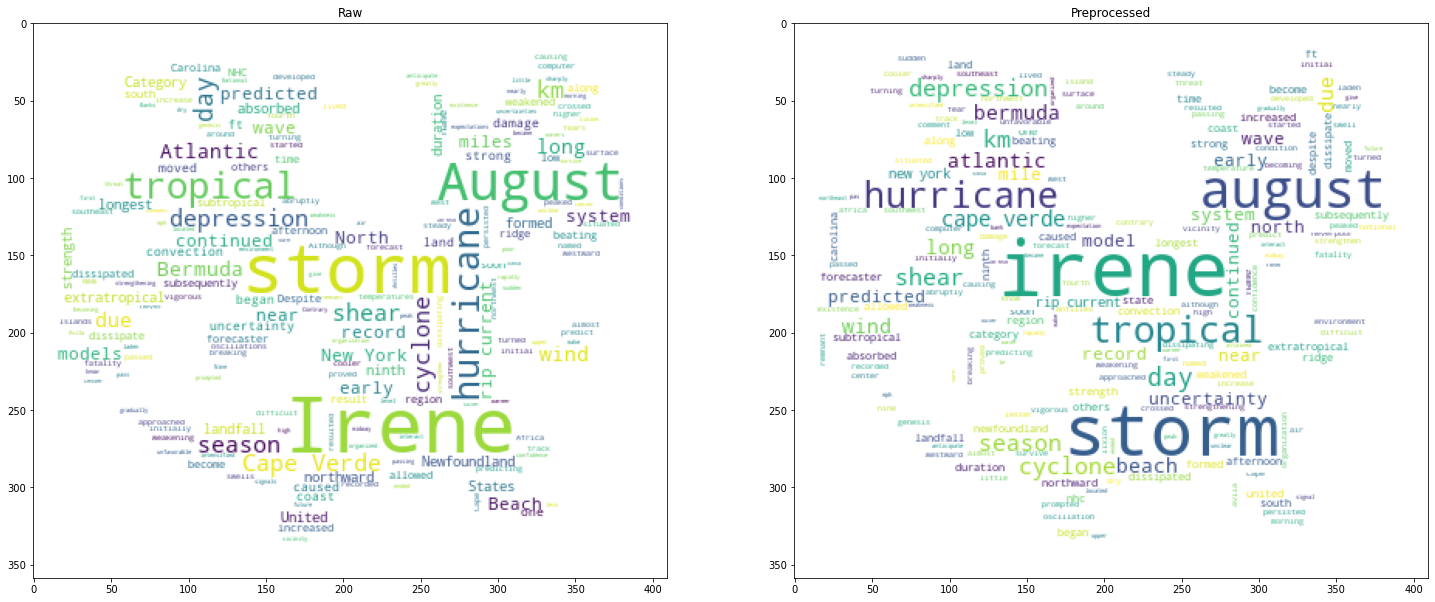

In [10]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## LSA Summary Generators

### Function to Generate BOW + LSA Summary

In [11]:
def generate_bow_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  """Generates an extractive summary using BOW feature generation scheme and LSA.

  Args:
    raw_sent_tokens(List[str]): An array containing all unprocessed sentences.
    pp_sent_tokens(List[str]): An array containing all preprocessed sentences.
    summary_size(int): Number of lines for summary as well as number of topics for LSA.
    ngram_tuple(tuple[int,int]): A tuple that species the ngram range for BOW feature extractoin scheme.

  Returns:
    A string that is the extractive summary for given article.
  """
  #instantiate BOW model
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) 

  #generate feature vector by training BOW model on preprocessed article
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) 

  #decompose feature vector into 3 matrices
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)

  #compute sentence scores
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))

  #sort the sentence scores in desceding oreder
  top_scores_index = np.argsort(sentence_scores)[::-1]

  #get the indices of highest scoring sentences
  top_scores_index = top_scores_index[0:summary_size]

  #convert raw sentence list from list type to numpy array
  article_array = np.array(raw_sent_tokens)

  #use the top scoring sentence indices to select sentences from raw article array
  bow_sum = list(article_array[top_scores_index])

  #convert the summary sentences from list to a single string
  bow_sum_str = " ".join(bow_sum)

  #return the string
  return bow_sum_str

### Function to Generate TF-IDF + LSA Summary

In [12]:
def generate_tfidf_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  """Generates an extractive summary using TF-IDF feature generation scheme and LSA.

  Args:
    raw_sent_tokens(List[str]): An array containing all unprocessed sentences.
    pp_sent_tokens(List[str]): An array containing all preprocessed sentences.
    summary_size(int): Number of lines for summary as well as number of topics for LSA.
    ngram_tuple(tuple[int,int]): A tuple that species the ngram range for BOW feature extractoin scheme.

  Returns:
    A string that is the extractive summary for given article.
  """  
  #instantiate TF-IDF model
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)

  #generate feature vector by training TF model on preprocessed article
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)

  #decompose feature vector into 3 matrices
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)

  #compute sentence scores
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))

  #sort the sentence scores in desceding order
  top_scores_index = np.argsort(sentence_scores)[::-1]

  #get the indices of highest scoring sentences
  top_scores_index = top_scores_index[0:summary_size]

  #convert raw sentence list from list type to numpy array
  article_array = np.array(raw_sent_tokens)

  #use the top scoring sentence indices to select sentences from raw article array
  tfidf_sum = list(article_array[top_scores_index])

  #convert the summary sentences from list to a single string
  tfidf_sum_str = " ".join(tfidf_sum)

  #return the string
  return tfidf_sum_str

### Function to Generate Word Embedding + LSA Summary

In [13]:
def create_word_to_vec_model(pp_sent_tokens, ngram=1):

  #create work tokens
  pp_article_st_wt = [word_tokenize(sent) for sent in pp_sent_tokens]

  if ngram <= 1:
    w2v_model = Word2Vec(sentences=pp_article_st_wt,
                        min_count = 5, 
                        window = 5,
                        vector_size=10,
                        sample=6e-5,
                        alpha=0.001,
                        min_alpha = 0.0007,
                        negative=20,
                        workers=num_cores-2)   
    return w2v_model

  else:
    #create n gram phraser
    ngram_model = None
    for i in range(2, ngram+1):
      ngram_model = gensim.models.phrases.Phrases(pp_article_st_wt)

    #create wor2vec model
    w2v_model = Word2Vec(sentences=ngram_model[pp_article_st_wt],
                          min_count = 5, 
                          window = 5,
                          vector_size=10,
                          sample=6e-5,
                          alpha=0.001,
                          min_alpha = 0.0007,
                          negative=20,
                          workers=num_cores-2)  

    return w2v_model

In [14]:
def generate_wemb_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  wemb_sum = list(article_array[top_scores_index])
  wemb_sum_str = " ".join(wemb_sum)
  return wemb_sum_str

### Function to Generated BOW + LSA + K-Means Summary

In [15]:
def generate_bow_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LSA + K-Means Summary

In [16]:
def generate_tfidf_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generated Word-Embeddings + LSA + K-Means Summary

In [17]:
def generate_wemb_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## LDA Summary Generators

### Function to Generate BOW + LDA Summary

In [18]:
def generate_bow_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)
  #return summary

### Function to Generate TF-IDF + LDA Summary

In [19]:
def generate_tfidf_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get TFIDF Features
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  print("TF-IDF Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generate Word Embedding + LDA Summary

In [20]:
def generate_wemb_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe for feature vector
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  #convert feature vector from dataframe to numpy
  feature_vector = dte_df.to_numpy()
  print("Wemb Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generated BOW + LDA + K-Means Summary

In [21]:
def generate_bow_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LDA + K-Means Summary

In [22]:
def generate_tfidf_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generate Word-Embeddings + LDA + K-Means Summary

In [23]:
def generate_wemb_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## Number of Lines in Summary

In [24]:
N_LINE = 10

## Generate Summaries for Uni-GRAM (1-GRAM) Occurence

### LSA

#### BOW

In [25]:
bow_lsa_1gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lsa_1gram_summary

'[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basi

#### TF-IDF

In [26]:
tfidf_lsa_1gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lsa_1gram_summary

"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. hurricane irene began as a cape verde storm. some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate. hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season. a vigorous tropical wave moved off the west coast of africa on august 1, initially weakening due to cooler sea surface temperatures. [1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never 

#### Word-Embeddings

In [27]:
wemb_lsa_1gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lsa_1gram_summary

"although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. [7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m). after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100

#### K-Means

##### BOW

In [28]:
bow_lsa_kmeans_1gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lsa_kmeans_1gram_summary

"[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11.[8][9] his body was recovered on august 16 after washing ashore.[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar.hurricane irene began as a cape verde storm.[8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic

##### TF-IDF

In [29]:
tfidf_lsa_kmeans_1gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lsa_kmeans_1gram_summary

'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.hurricane irene began as a cape verde storm.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11.a vigorous tropical wave moved off the west coast of africa on august 1, initially weakening due to cooler sea surface temperatures.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene

##### Word-Embeddings

In [30]:
wemb_lsa_kmeans_1gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lsa_kmeans_1gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around

### LDA

#### BOW

In [31]:
bow_lda_1gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'it was the ninth named storm and fourth hurricane of the record-breaking season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.hurricane irene began as a cape verde storm.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence" that the storm would survive.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dis

#### TF-IDF

In [32]:
tfidf_lda_1gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lda_1gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'irene proved to be a difficult storm to forecast due to oscillations in strength.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.the sudden threat to the storm\'s existence prompted national hurricane center (nhc) forecaster lixion avila to comment, "how little we know about the genesis of tropical cyclones."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence" that the storm would survive.[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while sout

#### Word-Embeddings

In [33]:
wemb_lda_1gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lda_1gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).a 16-year-old boy drowned after

#### K-Means

##### BOW

In [34]:
bow_lda_kmeans_1gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lda_kmeans_1gram_summary

'[1]\ndue to uncertainties about how the region\'s subtropical ridge would interact with irene, the models continued to give unclear signals of the storm\'s future.hurricane irene began as a cape verde storm.however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.a 16-year-old boy drowned after being caught in a rip current near long beach, new york on august 14.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.[8][9] his body was recovered on august 16 after washing ashore."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.it was the ninth named storm and fourth hurricane of the record-breaking season.after almost dissipating on august 10, irene peaked as a category 2 hurric

##### TF-IDF

In [35]:
tfidf_lda_kmeans_1gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lda_kmeans_1gram_summary

'[1]\nbecause irene was in an environment laden with dry air and high shear, it soon weakened to a tropical depression, on august 8.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.[8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basin at the time, beating the previous record held by a storm in the 1936 season by 13 days.[1]\ndue to uncertainties about how the region\'s subtropical ridge would interact with irene, the models continued to give unclear signals of the storm\'s future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensi

##### Word-Embeddings

In [36]:
wemb_lda_kmeans_1gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lda_kmeans_1gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge wo

## Generate Summaries For BI-GRAM (2-GRAM) Occurence

### LSA

#### BOW

In [37]:
bow_lsa_2gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lsa_2gram_summary

'[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basi

#### TF-IDF

In [38]:
tfidf_lsa_2gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lsa_2gram_summary

'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate. [1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. [4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on

#### Word-Embeddings

In [39]:
wemb_lsa_2gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lsa_2gram_summary

"although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. [7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m). after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100

#### K-Means

##### BOW

In [40]:
bow_lsa_kmeans_2gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lsa_kmeans_2gram_summary

'[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11.hurricane irene began as a cape verde storm.[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, s

##### TF-IDF

In [41]:
tfidf_lsa_kmeans_2gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lsa_kmeans_2gram_summary

'[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11.[8][9] his body was recovered on august 16 after washing ashore.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nbecause irene was in an environment laden with dry air and high shear, it soon weakened to a tropical depression, on august 8.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.however,

##### Word-Embeddings

In [42]:
wemb_lsa_kmeans_2gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lsa_kmeans_2gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around

### LDA

#### BOW

In [43]:
bow_lda_2gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.a vigorous tropical wave moved off the west coast of africa on august 1, initially weakening due to cooler sea surface temperatures.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would 

#### TF-IDF

In [44]:
tfidf_lda_2gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lda_2gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.a vigorous tropical wave moved off the west coast of africa on august 1, initially weakening due to cooler sea surface temperatures.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.some

#### Word-Embeddings

In [45]:
wemb_lda_2gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lda_2gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).a 16-year-old boy drowned after

#### K-Means

##### BOW

In [46]:
bow_lda_kmeans_2gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lda_kmeans_2gram_summary

'hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.[1]\nbecause irene was in an environment laden with dry air and high shear, it soon weakened to a tropical depression, on august 8.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.a vigorous tropical wave moved off the west coast of africa on august 1, initially weakening due to cooler sea surface temperatures.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate.this storm also marked the fifth occasion the name irene had been used to name a tropical cyclone in the atlantic.[6]\nas hurricane irene stayed well away from land, no coastal warnings or wat

##### TF-IDF

In [47]:
tfidf_lda_kmeans_2gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lda_kmeans_2gram_summary

'however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.irene proved to be a difficult storm to forecast due to oscillations in strength.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate.[5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august 18, when it was 520\xa0miles (830\xa0km) south of cape race, newfoundland.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.the sudden threat to the storm\'s existence prompted national hurricane center (nhc) forecaster lixion avila to comment, "how little we know about the genesis of tropical cyclones.all convection within 230\xa0mi (370\

##### Word-Embeddings

In [48]:
wemb_lda_kmeans_2gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lda_kmeans_2gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge wo

## Generate Summaries For Tri-GRAM (3-GRAM) Occurence

### LSA

#### BOW

In [49]:
bow_lsa_3gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lsa_3gram_summary

'[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august

#### TF-IDF

In [50]:
tfidf_lsa_3gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lsa_3gram_summary

'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. [5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august 18, when it was 520\xa0miles (830\xa0km) south of cape race, newfoundland. [3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11. although there were initial fears of a landfall in the united states due to 

#### Word-Embeddings

In [51]:
wemb_lsa_3gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lsa_3gram_summary

"although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. [7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m). after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100

#### K-Means

##### BOW

In [52]:
bow_lsa_kmeans_3gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lsa_kmeans_3gram_summary

'it moved westward and passed near cape verde, where convection started to increase.[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar.[8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basin at the time, beating the previous record held by a storm in the 1936 season by 13 days.[5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on

##### TF-IDF

In [53]:
tfidf_lsa_kmeans_3gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lsa_kmeans_3gram_summary

'[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\nbecause irene was in an environment laden with dry air and high shear, it soon weakened to a tropical depression, on august 8.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cy

##### Word-Embeddings

In [54]:
wemb_lsa_kmeans_3gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lsa_kmeans_3gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around

### LDA

#### BOW

In [55]:
bow_lda_3gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dis

#### TF-IDF

In [56]:
tfidf_lda_3gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lda_3gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.the sudden threat to the storm\'s existence prompted national hurricane center (nhc) forecaster lixion avila to comm

#### Word-Embeddings

In [57]:
wemb_lda_3gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lda_3gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).a 16-year-old boy drowned after

#### K-Means

##### BOW

In [58]:
bow_lda_kmeans_3gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lda_kmeans_3gram_summary

'it moved westward and passed near cape verde, where convection started to increase.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence" that the storm would survive.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, cau

##### TF-IDF

In [59]:
tfidf_lda_kmeans_3gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lda_kmeans_3gram_summary

'[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august 18, when it was 520\xa0miles (830\xa0km) south of cape race, newfoundland.irene proved to be a difficult storm to forecast due to oscillations in strength.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate.however, this record has since been surpassed by hurricane is

##### Word-Embeddings

In [60]:
wemb_lda_kmeans_3gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lda_kmeans_3gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge wo

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### LSA

#### BOW

In [61]:
bow_lsa_4gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lsa_4gram_summary

'[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august

#### TF-IDF

In [62]:
tfidf_lsa_4gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lsa_4gram_summary

"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period. [3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it became a tropical storm once again early on august 11. [5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august 18, when it was 520\xa0miles (830\xa0km) south of cape race, newfoundland. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, h

#### Word-Embeddings

In [63]:
wemb_lsa_4gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 4)
wemb_lsa_4gram_summary

"although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. [7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m). after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100

#### K-Means

##### BOW

In [64]:
bow_lsa_kmeans_4gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lsa_kmeans_4gram_summary

'all convection within 230\xa0mi (370\xa0km) of the cyclone dissipated on august\xa018. irene was subsequently absorbed by an extratropical cyclone later that day.[8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basin at the time, beating the previous record held by a storm in the 1936 season by 13 days.[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar.[5]\nirene entered a region of increased wind shear and 

##### TF-IDF

In [65]:
tfidf_lsa_kmeans_4gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lsa_kmeans_4gram_summary

"[8]\nwhen tropical storm irene formed on august 7, it was the earliest date for the formation of the ninth tropical storm in the atlantic basin at the time, beating the previous record held by a storm in the 1936 season by 13 days.irene proved to be a difficult storm to forecast due to oscillations in strength.all convection within 230\xa0mi (370\xa0km) of the cyclone dissipated on august\xa018. irene was subsequently absorbed by an extratropical cyclone later that day.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.the system subsequently developed into a tropical depression on the aftern

##### Word-Embeddings

In [66]:
wemb_lsa_kmeans_4gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lsa_kmeans_4gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around

### LDA

#### BOW

In [67]:
bow_lda_4gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening."[2] despite the unfavorable conditions in its vicinity and its poor organiza

#### TF-IDF

In [68]:
tfidf_lda_4gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lda_4gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence

#### Word-Embeddings

In [69]:
wemb_lda_4gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_4gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).a 16-year-old boy drowned after

#### K-Means

##### BOW

In [70]:
bow_lda_kmeans_4gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lda_kmeans_4gram_summary

'[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.a 16-year-old boy drowned after being caught in a rip current near long beach, new york on august 14.[6]\nas hurricane irene stayed well away from land, no coastal warnings or watches were issued for it.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence" that the storm would survive.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.this storm also marked the fifth occasion the name irene had been used to name a tropical cyclone in the atlantic.the system subsequently developed into a trop

##### TF-IDF

In [71]:
tfidf_lda_kmeans_4gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lda_kmeans_4gram_summary

'[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.this storm also marked the fifth occasion the name irene had been used to name a tropical cyclone in the atlantic.a 16-year-old boy drowned after being caught in a rip current near long beach, new york on august 14.[6]\nas hurricane irene stayed well away from land, no coastal warnings or watches were issued for it.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipated into a remnant low, but forecasters predicted with "very low confidence" that the storm would survive.[3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually m

##### Word-Embeddings

In [72]:
wemb_lda_kmeans_4gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_kmeans_4gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge wo

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### LSA

#### BOW

In [73]:
bow_lsa_5gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lsa_5gram_summary

'[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar. although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on august

#### TF-IDF

In [74]:
tfidf_lsa_5gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lsa_5gram_summary

"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period. it was the ninth named storm and fourth hurricane of the record-breaking season. [1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future. however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days. [3] contrary to these expectations, warmer waters and less wind shear allowed irene to become gradually more organized while south of bermuda, and it becam

#### Word-Embeddings

In [75]:
wemb_lsa_5gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_5gram_summary

"although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york. [1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season. [7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m). after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland. the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100

#### K-Means


##### BOW

In [76]:
bow_lsa_kmeans_5gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lsa_kmeans_5gram_summary

'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.[4] the uncertainty ended when a weakness in the subtropical ridge allowed irene to turn sharply northward, which caused the storm to pass midway between the outer banks of north carolina and bermuda on august 15. soon after, upper-level shear weakened greatly, and irene rapidly intensified, first to a hurricane, then to its peak strength as a 105\xa0mph (170\xa0km/h) category 2 hurricane on the afternoon of august 16, while located 350\xa0miles (560\xa0km) northeast of bermuda; at the same time it also attained minimum pressure of 970\xa0mbar.[5]\nirene entered a region of increased wind shear and began to weaken, and as a result it was downgraded t

##### TF-IDF

In [77]:
tfidf_lsa_kmeans_5gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lsa_kmeans_5gram_summary

'[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.it was the ninth named storm and fourth hurricane of the record-breaking season."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.all convection within 230\xa0mi (370\xa0km) of the cyclone dissipated on august\xa018. irene was subsequently absorbed by an extratropical cyclone later that day.[1] though nhc meteorologists thought it was likely that irene would become a hurricane, they were not expecting an intensification of such a magnitude.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[8][9] his body was recovered on august 16 after washing ashore.[1] on the morning of august 10, as it was passing north of the lesser antilles, irene nearly dissipate

##### Word-Embeddings

In [78]:
wemb_lsa_kmeans_5gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_kmeans_5gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around bermuda before being absorbed by an extratropical cyclone while situated southeast of newfoundland.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the storm formed near cape verde on august 4 and crossed the atlantic, turning northward around

### LDA

#### BOW

In [79]:
bow_lda_5gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.the sudden threat to the storm\'s existence prompted national hurricane center (nhc) forecaster lixion avila to comment, "how little we know about the genesis of tropical cyclones."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical 

#### TF-IDF

In [80]:
tfidf_lda_5gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lda_5gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm\'s track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.[4] the uncertainty ended when a weakness in the subtropical ridge allow

#### Word-Embeddings

In [81]:
wemb_lda_5gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 5)
wemb_lda_5gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.although there were initial fears of a landfall in the united states due to uncertainty in predicting the storm's track, hurricane irene never approached land and caused no recorded damage; however, swells up to 8\xa0ft (2.4\xa0m) and strong rip currents resulted in one fatality in long beach, new york.[1] irene lasted for 14\xa0days as a tropical system, the longest duration of any storm of the 2005 season.[1]\nhowever, the hurricane generated strong waves and increased the risk of rip currents along the east coast of the united states.many beaches in new jersey restricted swimming activities, and lifeguards at one beach performed more than a hundred rescues over a three-day period.[7] waves along the coastline of new york reached 4 to 8\xa0ft (1.2 to 2.4\xa0m).a 16-year-old boy drowned after

#### K-Means

##### BOW

In [82]:
bow_lda_kmeans_5gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lda_kmeans_5gram_summary

'[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear, causing some computer models to predict that the depression would dissipate, while others predicted steady strengthening.hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.hurricane irene began as a cape verde storm.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.it moved westward and passed near cape verde, where convection started to increase.the sudden threat to the storm\'s existence prompted national hurricane center (nhc) forecaster lixion avila to comment, "how little we know about the genesis of tropical cyclones.however, this record has since been su

##### TF-IDF

In [83]:
tfidf_lda_kmeans_5gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lda_kmeans_5gram_summary

'hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.it moved westward and passed near cape verde, where convection started to increase.despite irene\'s long life there were no reports of tropical storm force winds affecting ships.however, this record has since been surpassed by hurricane isaias in 2020, which gained tropical storm status on july 30, beating irene by 8 days.some of the models predicted that irene would make landfall in north carolina, while others continued to anticipate that irene would dissipate."[2] despite the unfavorable conditions in its vicinity and its poor organization, tropical depression nine continued to strengthen, becoming tropical storm irene on august 7.[1] early on august 5, the depression abruptly turned to the northwest into an area of higher wind shear,

##### Word-Embeddings

In [84]:
wemb_lda_kmeans_5gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lda_kmeans_5gram_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


"hurricane irene was a long-lived cape verde hurricane during the 2005 atlantic hurricane season.after almost dissipating on august 10, irene peaked as a category 2 hurricane on august 16. irene persisted for 14 days as a tropical system, the longest duration of any storm of the 2005 season.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.the system subsequently developed into a tropical depression on the afternoon of august\xa04, 690\xa0miles (1100\xa0km) southwest of the cape verde islands.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge would interact with irene, the models continued to give unclear signals of the storm's future.[1]\ndue to uncertainties about how the region's subtropical ridge wo

## Summaries Generated Via Survery

In [85]:
survey_summary2 = "Hurricane Irene was a long-lived Cape Verde hurricane during the 2005 Atlantic hurricane season. It was the ninth named storm and fourth hurricane of the record-breaking season. Although there were initial fears of a landfall in the United States due to uncertainty in predicting the storm's track, Hurricane Irene never approached land and caused no recorded damage; however, swells up to 8 ft (2.4 m) and strong rip currents resulted in one fatality in Long Beach, New York. Despite the unfavorable conditions in its vicinity and its poor organization, Tropical Depression Nine continued to strengthen, becoming Tropical Storm Irene on August 7. Contrary to these expectations, warmer waters and less wind shear allowed Irene to become gradually more organized while south of Bermuda, and it became a tropical storm once again early on August 11. Though NHC meteorologists thought it was likely that Irene would become a hurricane, they were not expecting an intensification of such a magnitude. Irene entered a region of increased wind shear and began to weaken, and as a result it was downgraded to a tropical storm early on August 18, when it was 520 miles (830 km) south of Cape Race, Newfoundland. Irene lasted for 14 days as a tropical system, the longest duration of any storm of the 2005 season. However, the hurricane generated strong waves and increased the risk of rip currents along the East Coast of the United States. This storm also marked the fifth occasion the name Irene had been used to name a tropical cyclone in the Atlantic."
survey_summary2

"Hurricane Irene was a long-lived Cape Verde hurricane during the 2005 Atlantic hurricane season. It was the ninth named storm and fourth hurricane of the record-breaking season. Although there were initial fears of a landfall in the United States due to uncertainty in predicting the storm's track, Hurricane Irene never approached land and caused no recorded damage; however, swells up to 8 ft (2.4 m) and strong rip currents resulted in one fatality in Long Beach, New York. Despite the unfavorable conditions in its vicinity and its poor organization, Tropical Depression Nine continued to strengthen, becoming Tropical Storm Irene on August 7. Contrary to these expectations, warmer waters and less wind shear allowed Irene to become gradually more organized while south of Bermuda, and it became a tropical storm once again early on August 11. Though NHC meteorologists thought it was likely that Irene would become a hurricane, they were not expecting an intensification of such a magnitude. I

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

## Function to evaluate N-gram summary

In [86]:
def get_ngram_rouge(ngram, generated_summary, survey_summary):
  scorer = rouge_scorer.RougeScorer([f'rouge{ngram}'], use_stemmer=False)
  scores = scorer.score(generated_summary, survey_summary)[f"rouge{ngram}"]
  return scores

### 1-GRAM

#### LSA

In [87]:
bow_lsa_1gram_rouge = get_ngram_rouge(1, bow_lsa_1gram_summary, survey_summary2)
bow_lsa_1gram_rouge

Score(precision=0.7404580152671756, recall=0.4837905236907731, fmeasure=0.5852187028657617)

In [88]:
tfidf_lsa_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_1gram_summary, survey_summary2)
tfidf_lsa_1gram_rouge

Score(precision=0.6030534351145038, recall=0.6448979591836734, fmeasure=0.6232741617357002)

In [89]:
wemb_lsa_1gram_rouge = get_ngram_rouge(1, wemb_lsa_1gram_summary, survey_summary2)
wemb_lsa_1gram_rouge

Score(precision=0.6297709923664122, recall=0.4796511627906977, fmeasure=0.5445544554455445)

In [90]:
bow_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lsa_kmeans_1gram_summary, survey_summary2)
bow_lsa_kmeans_1gram_rouge

Score(precision=0.6755725190839694, recall=0.5, fmeasure=0.5746753246753247)

In [91]:
tfidf_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_kmeans_1gram_summary, survey_summary2)
tfidf_lsa_kmeans_1gram_rouge

Score(precision=0.5687022900763359, recall=0.6260504201680672, fmeasure=0.596)

In [92]:
wemb_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lsa_kmeans_1gram_summary, survey_summary2)
wemb_lsa_kmeans_1gram_rouge

Score(precision=0.3893129770992366, recall=0.4322033898305085, fmeasure=0.4096385542168674)

#### LDA

In [93]:
bow_lda_1gram_rouge = get_ngram_rouge(1, bow_lda_1gram_summary, survey_summary2)
bow_lda_1gram_rouge

Score(precision=0.7442748091603053, recall=0.529891304347826, fmeasure=0.619047619047619)

In [94]:
tfidf_lda_1gram_rouge = get_ngram_rouge(1, tfidf_lda_1gram_summary, survey_summary2)
tfidf_lda_1gram_rouge

Score(precision=0.6526717557251909, recall=0.46216216216216216, fmeasure=0.5411392405063291)

In [95]:
wemb_lda_1gram_rouge = get_ngram_rouge(1, wemb_lda_1gram_summary, survey_summary2)
wemb_lda_1gram_rouge

Score(precision=0.6259541984732825, recall=0.6051660516605166, fmeasure=0.6153846153846154)

In [96]:
bow_lda_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lda_kmeans_1gram_summary, survey_summary2)
bow_lda_kmeans_1gram_rouge

Score(precision=0.4961832061068702, recall=0.6046511627906976, fmeasure=0.5450733752620545)

In [97]:
tfidf_lda_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lda_kmeans_1gram_summary, survey_summary2)
tfidf_lda_kmeans_1gram_rouge

Score(precision=0.583969465648855, recall=0.5543478260869565, fmeasure=0.5687732342007434)

In [98]:
wemb_lda_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lda_kmeans_1gram_summary, survey_summary2)
wemb_lda_kmeans_1gram_rouge

Score(precision=0.36259541984732824, recall=0.3612167300380228, fmeasure=0.3619047619047619)

### 2-GRAM

#### LSA

In [99]:
bow_lsa_2gram_rouge = get_ngram_rouge(2, bow_lsa_2gram_summary, survey_summary2)
bow_lsa_2gram_rouge

Score(precision=0.5823754789272031, recall=0.35764705882352943, fmeasure=0.44314868804664725)

In [100]:
tfidf_lsa_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_2gram_summary, survey_summary2)
tfidf_lsa_2gram_rouge

Score(precision=0.31417624521072796, recall=0.2733333333333333, fmeasure=0.29233511586452765)

In [101]:
wemb_lsa_2gram_rouge = get_ngram_rouge(2, wemb_lsa_2gram_summary, survey_summary2)
wemb_lsa_2gram_rouge

Score(precision=0.3524904214559387, recall=0.26822157434402333, fmeasure=0.304635761589404)

In [102]:
bow_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lsa_kmeans_2gram_summary, survey_summary2)
bow_lsa_kmeans_2gram_rouge

Score(precision=0.5938697318007663, recall=0.39845758354755784, fmeasure=0.47692307692307695)

In [103]:
tfidf_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_kmeans_2gram_summary, survey_summary2)
tfidf_lsa_kmeans_2gram_rouge

Score(precision=0.42911877394636017, recall=0.4628099173553719, fmeasure=0.44532803180914515)

In [104]:
wemb_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lsa_kmeans_2gram_summary, survey_summary2)
wemb_lsa_kmeans_2gram_rouge

Score(precision=0.16091954022988506, recall=0.17872340425531916, fmeasure=0.16935483870967744)

#### LDA

In [105]:
bow_lda_2gram_rouge = get_ngram_rouge(2, bow_lda_2gram_summary, survey_summary2)
bow_lda_2gram_rouge

Score(precision=0.42911877394636017, recall=0.2909090909090909, fmeasure=0.34674922600619196)

In [106]:
tfidf_lda_2gram_rouge = get_ngram_rouge(2, tfidf_lda_2gram_summary, survey_summary2)
tfidf_lda_2gram_rouge

Score(precision=0.578544061302682, recall=0.4005305039787798, fmeasure=0.47335423197492155)

In [107]:
wemb_lda_2gram_rouge = get_ngram_rouge(2, wemb_lda_2gram_summary, survey_summary2)
wemb_lda_2gram_rouge

Score(precision=0.4789272030651341, recall=0.46296296296296297, fmeasure=0.4708097928436911)

In [108]:
bow_lda_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lda_kmeans_2gram_summary, survey_summary2)
bow_lda_kmeans_2gram_rouge

Score(precision=0.38697318007662834, recall=0.44298245614035087, fmeasure=0.41308793456032716)

In [109]:
tfidf_lda_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lda_kmeans_2gram_summary, survey_summary2)
tfidf_lda_kmeans_2gram_rouge

Score(precision=0.2950191570881226, recall=0.2972972972972973, fmeasure=0.29615384615384616)

In [110]:
wemb_lda_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lda_kmeans_2gram_summary, survey_summary2)
wemb_lda_kmeans_2gram_rouge

Score(precision=0.15708812260536398, recall=0.15648854961832062, fmeasure=0.15678776290630977)

### 3-GRAM

#### LSA

In [111]:
bow_lsa_3gram_rouge = get_ngram_rouge(3, bow_lsa_3gram_summary, survey_summary2)
bow_lsa_3gram_rouge

Score(precision=0.5307692307692308, recall=0.32547169811320753, fmeasure=0.40350877192982454)

In [112]:
tfidf_lsa_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_3gram_summary, survey_summary2)
tfidf_lsa_3gram_rouge

Score(precision=0.6153846153846154, recall=0.5128205128205128, fmeasure=0.5594405594405595)

In [113]:
wemb_lsa_3gram_rouge = get_ngram_rouge(3, wemb_lsa_3gram_summary, survey_summary2)
wemb_lsa_3gram_rouge

Score(precision=0.2692307692307692, recall=0.2046783625730994, fmeasure=0.2325581395348837)

In [114]:
bow_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lsa_kmeans_3gram_summary, survey_summary2)
bow_lsa_kmeans_3gram_rouge

Score(precision=0.5307692307692308, recall=0.3382352941176471, fmeasure=0.41317365269461076)

In [115]:
tfidf_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_kmeans_3gram_summary, survey_summary2)
tfidf_lsa_kmeans_3gram_rouge

Score(precision=0.5, recall=0.41533546325878595, fmeasure=0.4537521815008726)

In [116]:
wemb_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lsa_kmeans_3gram_summary, survey_summary2)
wemb_lsa_kmeans_3gram_rouge

Score(precision=0.11153846153846154, recall=0.12393162393162394, fmeasure=0.1174089068825911)

#### LDA

In [117]:
bow_lda_3gram_rouge = get_ngram_rouge(3, bow_lda_3gram_summary, survey_summary2)
bow_lda_3gram_rouge

Score(precision=0.6807692307692308, recall=0.4621409921671018, fmeasure=0.5505443234836703)

In [118]:
tfidf_lda_3gram_rouge = get_ngram_rouge(3, tfidf_lda_3gram_summary, survey_summary2)
tfidf_lda_3gram_rouge

Score(precision=0.5230769230769231, recall=0.35142118863049093, fmeasure=0.42040185471406494)

In [119]:
wemb_lda_3gram_rouge = get_ngram_rouge(3, wemb_lda_3gram_summary, survey_summary2)
wemb_lda_3gram_rouge

Score(precision=0.4230769230769231, recall=0.40892193308550184, fmeasure=0.4158790170132325)

In [120]:
bow_lda_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lda_kmeans_3gram_summary, survey_summary2)
bow_lda_kmeans_3gram_rouge

Score(precision=0.09615384615384616, recall=0.10775862068965517, fmeasure=0.1016260162601626)

In [121]:
tfidf_lda_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lda_kmeans_3gram_summary, survey_summary2)
tfidf_lda_kmeans_3gram_rouge

Score(precision=0.2153846153846154, recall=0.23333333333333334, fmeasure=0.22400000000000003)

In [122]:
wemb_lda_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lda_kmeans_3gram_summary, survey_summary2)
wemb_lda_kmeans_3gram_rouge

Score(precision=0.11153846153846154, recall=0.1111111111111111, fmeasure=0.11132437619961612)

### 4-GRAM

#### LSA

In [123]:
bow_lsa_4gram_rouge = get_ngram_rouge(4, bow_lsa_4gram_summary, survey_summary2)
bow_lsa_4gram_rouge

Score(precision=0.5019305019305019, recall=0.3073286052009456, fmeasure=0.3812316715542522)

In [124]:
tfidf_lsa_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_4gram_summary, survey_summary2)
tfidf_lsa_4gram_rouge

Score(precision=0.5521235521235521, recall=0.5238095238095238, fmeasure=0.5375939849624061)

In [125]:
wemb_lsa_4gram_rouge = get_ngram_rouge(4, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_4gram_rouge

Score(precision=0.2548262548262548, recall=0.1935483870967742, fmeasure=0.22)

In [126]:
bow_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lsa_kmeans_4gram_summary, survey_summary2)
bow_lsa_kmeans_4gram_rouge

Score(precision=0.5019305019305019, recall=0.31026252983293556, fmeasure=0.38348082595870203)

In [127]:
tfidf_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_kmeans_4gram_summary, survey_summary2)
tfidf_lsa_kmeans_4gram_rouge

Score(precision=0.41312741312741313, recall=0.38489208633093525, fmeasure=0.3985102420856611)

In [128]:
wemb_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lsa_kmeans_4gram_summary, survey_summary2)
wemb_lsa_kmeans_4gram_rouge

Score(precision=0.10038610038610038, recall=0.11158798283261803, fmeasure=0.10569105691056911)

#### LDA

In [129]:
bow_lda_4gram_rouge = get_ngram_rouge(4, bow_lda_4gram_summary, survey_summary2)
bow_lda_4gram_rouge

Score(precision=0.4092664092664093, recall=0.27676240208877284, fmeasure=0.3302180685358255)

In [130]:
tfidf_lda_4gram_rouge = get_ngram_rouge(4, tfidf_lda_4gram_summary, survey_summary2)
tfidf_lda_4gram_rouge

Score(precision=0.23938223938223938, recall=0.16986301369863013, fmeasure=0.1987179487179487)

In [131]:
wemb_lda_4gram_rouge = get_ngram_rouge(4, wemb_lda_4gram_summary, survey_summary2)
wemb_lda_4gram_rouge

Score(precision=0.39768339768339767, recall=0.3843283582089552, fmeasure=0.39089184060721055)

In [132]:
bow_lda_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lda_kmeans_4gram_summary, survey_summary2)
bow_lda_kmeans_4gram_rouge

Score(precision=0.28185328185328185, recall=0.3395348837209302, fmeasure=0.30801687763713076)

In [133]:
tfidf_lda_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lda_kmeans_4gram_summary, survey_summary2)
tfidf_lda_kmeans_4gram_rouge

Score(precision=0.2972972972972973, recall=0.3181818181818182, fmeasure=0.3073852295409182)

In [134]:
wemb_lda_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lda_kmeans_4gram_summary, survey_summary2)
wemb_lda_kmeans_4gram_rouge

Score(precision=0.10038610038610038, recall=0.1, fmeasure=0.1001926782273603)

### 5-GRAM

#### LSA

In [135]:
bow_lsa_5gram_rouge = get_ngram_rouge(5, bow_lsa_5gram_summary, survey_summary2)
bow_lsa_5gram_rouge

Score(precision=0.4883720930232558, recall=0.2985781990521327, fmeasure=0.3705882352941176)

In [136]:
tfidf_lsa_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_5gram_summary, survey_summary2)
tfidf_lsa_5gram_rouge

Score(precision=0.20930232558139536, recall=0.2076923076923077, fmeasure=0.20849420849420852)

In [137]:
wemb_lsa_5gram_rouge = get_ngram_rouge(5, wemb_lsa_5gram_summary, survey_summary2)
wemb_lsa_5gram_rouge

Score(precision=0.24806201550387597, recall=0.18823529411764706, fmeasure=0.2140468227424749)

In [138]:
bow_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lsa_kmeans_5gram_summary, survey_summary2)
bow_lsa_kmeans_5gram_rouge

Score(precision=0.49224806201550386, recall=0.3031026252983294, fmeasure=0.3751846381093058)

In [139]:
tfidf_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_kmeans_5gram_summary, survey_summary2)
tfidf_lsa_kmeans_5gram_rouge

Score(precision=0.29457364341085274, recall=0.3584905660377358, fmeasure=0.3234042553191489)

In [140]:
wemb_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lsa_kmeans_5gram_summary, survey_summary2)
wemb_lsa_kmeans_5gram_rouge

Score(precision=0.09302325581395349, recall=0.10344827586206896, fmeasure=0.0979591836734694)

#### LDA

In [141]:
bow_lda_5gram_rouge = get_ngram_rouge(5, bow_lda_5gram_summary, survey_summary2)
bow_lda_5gram_rouge

Score(precision=0.5232558139534884, recall=0.3333333333333333, fmeasure=0.40723981900452494)

In [142]:
tfidf_lda_5gram_rouge = get_ngram_rouge(5, tfidf_lda_5gram_summary, survey_summary2)
tfidf_lda_5gram_rouge

Score(precision=0.5, recall=0.3449197860962567, fmeasure=0.4082278481012658)

In [143]:

wemb_lda_5gram_rouge = get_ngram_rouge(5, wemb_lda_5gram_summary, survey_summary2)
wemb_lda_5gram_rouge

Score(precision=0.38372093023255816, recall=0.3707865168539326, fmeasure=0.37714285714285717)

In [144]:
bow_lda_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lda_kmeans_5gram_summary, survey_summary2)
bow_lda_kmeans_5gram_rouge

Score(precision=0.12015503875968993, recall=0.14485981308411214, fmeasure=0.1313559322033898)

In [145]:
tfidf_lda_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lda_kmeans_5gram_summary, survey_summary2)
tfidf_lda_kmeans_5gram_rouge

Score(precision=0.12015503875968993, recall=0.14485981308411214, fmeasure=0.1313559322033898)

In [146]:
wemb_lda_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lda_kmeans_5gram_summary, survey_summary2)
wemb_lda_kmeans_5gram_rouge

Score(precision=0.09302325581395349, recall=0.09266409266409266, fmeasure=0.0928433268858801)

## Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores 

###LSA

In [147]:
lsa_comparision_df = pd.DataFrame()
lsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lsa_comparision_df["BOW_Recall"] = [bow_lsa_1gram_rouge.recall, bow_lsa_2gram_rouge.recall, bow_lsa_3gram_rouge.recall, bow_lsa_4gram_rouge.recall, bow_lsa_5gram_rouge.recall]
lsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_1gram_rouge.recall, tfidf_lsa_2gram_rouge.recall, tfidf_lsa_3gram_rouge.recall, tfidf_lsa_4gram_rouge.recall, tfidf_lsa_5gram_rouge.recall]
lsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lsa_2gram_rouge.recall, wemb_lsa_3gram_rouge.recall, wemb_lsa_4gram_rouge.recall, wemb_lsa_5gram_rouge.recall]


lsa_comparision_df["BOW_Precision"] = [bow_lsa_1gram_rouge.precision, bow_lsa_2gram_rouge.precision, bow_lsa_3gram_rouge.precision, bow_lsa_4gram_rouge.precision, bow_lsa_5gram_rouge.precision]
lsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_1gram_rouge.precision, tfidf_lsa_2gram_rouge.precision, tfidf_lsa_3gram_rouge.precision, tfidf_lsa_4gram_rouge.precision, tfidf_lsa_5gram_rouge.precision]
lsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_1gram_rouge.precision, wemb_lsa_2gram_rouge.precision, wemb_lsa_3gram_rouge.precision, wemb_lsa_4gram_rouge.precision, wemb_lsa_5gram_rouge.precision]


lsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_1gram_rouge.fmeasure, bow_lsa_2gram_rouge.fmeasure, bow_lsa_3gram_rouge.fmeasure, bow_lsa_4gram_rouge.fmeasure, bow_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_1gram_rouge.fmeasure, wemb_lsa_2gram_rouge.fmeasure, wemb_lsa_3gram_rouge.fmeasure, wemb_lsa_4gram_rouge.fmeasure, wemb_lsa_5gram_rouge.fmeasure]

lsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.483791,0.644898,0.479651,0.740458,0.603053,0.629771,0.585219,0.623274,0.544554
1,2-Gram,0.357647,0.273333,0.268222,0.582375,0.314176,0.352490,0.443149,0.292335,0.304636
2,3-Gram,0.325472,0.512821,0.204678,0.530769,0.615385,0.269231,0.403509,0.559441,0.232558
3,4-Gram,0.307329,0.523810,0.193548,0.501931,0.552124,0.254826,0.381232,0.537594,0.220000
4,5-Gram,0.298578,0.207692,0.188235,0.488372,0.209302,0.248062,0.370588,0.208494,0.214047


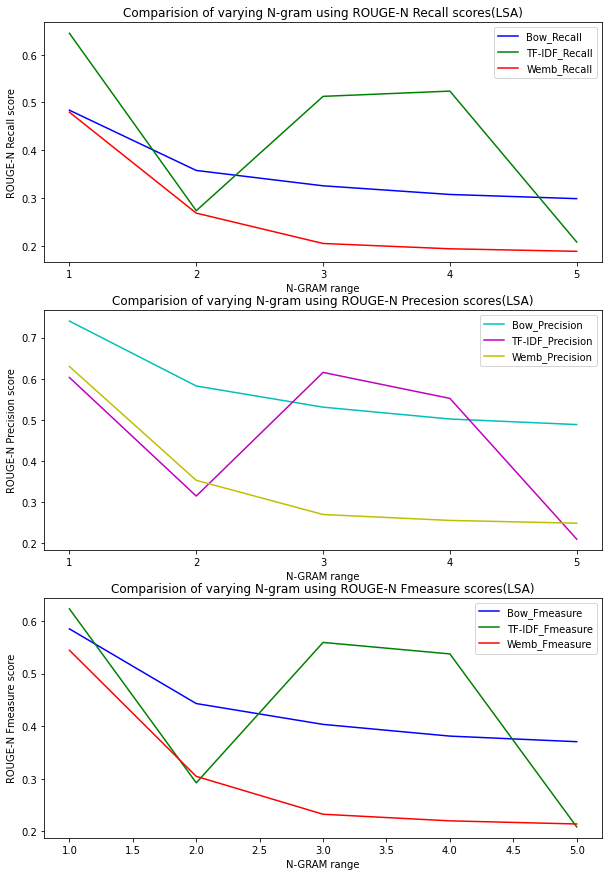

In [148]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### LDA

In [149]:
lda_comparision_df = pd.DataFrame()
lda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lda_comparision_df["BOW_Recall"] = [bow_lda_1gram_rouge.recall, bow_lda_2gram_rouge.recall, bow_lda_3gram_rouge.recall, bow_lda_4gram_rouge.recall, bow_lda_5gram_rouge.recall]
lda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_1gram_rouge.recall, tfidf_lda_2gram_rouge.recall, tfidf_lda_3gram_rouge.recall, tfidf_lda_4gram_rouge.recall, tfidf_lda_5gram_rouge.recall]
lda_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lda_2gram_rouge.recall, wemb_lda_3gram_rouge.recall, wemb_lda_4gram_rouge.recall, wemb_lda_5gram_rouge.recall]

lda_comparision_df["BOW_Precision"] = [bow_lda_1gram_rouge.precision, bow_lda_2gram_rouge.precision, bow_lda_3gram_rouge.precision, bow_lda_4gram_rouge.precision, bow_lda_5gram_rouge.precision]
lda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_1gram_rouge.precision, tfidf_lda_2gram_rouge.precision, tfidf_lda_3gram_rouge.precision, tfidf_lda_4gram_rouge.precision, tfidf_lda_5gram_rouge.precision]
lda_comparision_df["W-Emb_Precision"] = [wemb_lda_1gram_rouge.precision, wemb_lda_2gram_rouge.precision, wemb_lda_3gram_rouge.precision, wemb_lda_4gram_rouge.precision, wemb_lda_5gram_rouge.precision]

lda_comparision_df["BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]
lda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_1gram_rouge.fmeasure, tfidf_lda_2gram_rouge.fmeasure, tfidf_lda_3gram_rouge.fmeasure, tfidf_lda_4gram_rouge.fmeasure, tfidf_lda_5gram_rouge.fmeasure]
lda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_1gram_rouge.fmeasure, wemb_lda_2gram_rouge.fmeasure, wemb_lda_3gram_rouge.fmeasure, wemb_lda_4gram_rouge.fmeasure, wemb_lda_5gram_rouge.fmeasure]

lda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.529891,0.462162,0.479651,0.744275,0.652672,0.625954,0.619048,0.541139,0.615385
1,2-Gram,0.290909,0.400531,0.462963,0.429119,0.578544,0.478927,0.346749,0.473354,0.470810
2,3-Gram,0.462141,0.351421,0.408922,0.680769,0.523077,0.423077,0.550544,0.420402,0.415879
3,4-Gram,0.276762,0.169863,0.384328,0.409266,0.239382,0.397683,0.330218,0.198718,0.390892
4,5-Gram,0.333333,0.344920,0.370787,0.523256,0.500000,0.383721,0.407240,0.408228,0.377143


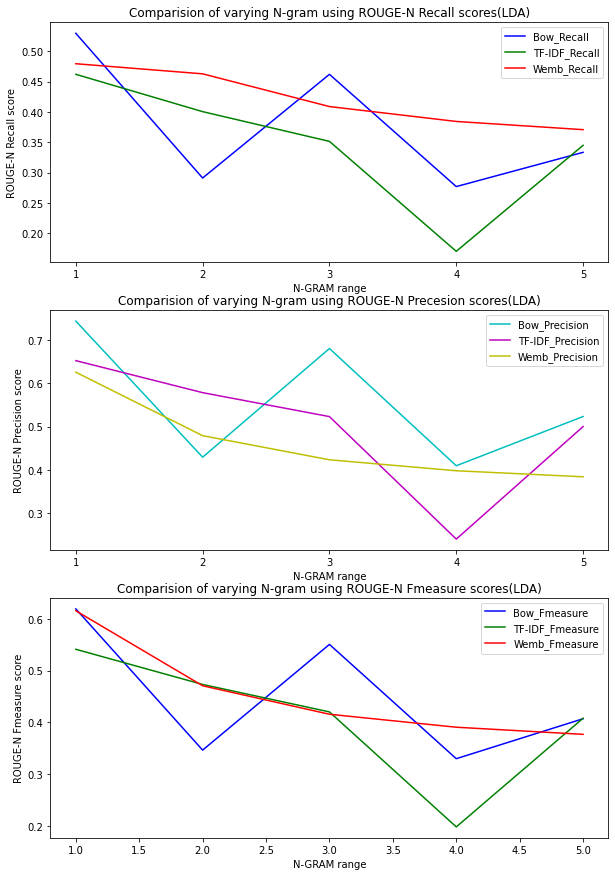

In [150]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### K-Means

#### LSA

In [151]:
klsa_comparision_df = pd.DataFrame()
klsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]


klsa_comparision_df["BOW_Recall"] = [bow_lsa_kmeans_1gram_rouge.recall,
                                     bow_lsa_kmeans_2gram_rouge.recall, 
                                     bow_lsa_kmeans_3gram_rouge.recall, 
                                     bow_lsa_kmeans_4gram_rouge.recall, 
                                     bow_lsa_kmeans_5gram_rouge.recall]

klsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_kmeans_1gram_rouge.recall, 
                                        tfidf_lsa_kmeans_2gram_rouge.recall, 
                                        tfidf_lsa_kmeans_3gram_rouge.recall, 
                                        tfidf_lsa_kmeans_4gram_rouge.recall, 
                                        tfidf_lsa_kmeans_5gram_rouge.recall]

klsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_kmeans_1gram_rouge.recall, 
                                       wemb_lsa_kmeans_2gram_rouge.recall, 
                                       wemb_lsa_kmeans_3gram_rouge.recall, 
                                       wemb_lsa_kmeans_4gram_rouge.recall, 
                                       wemb_lsa_kmeans_5gram_rouge.recall]




klsa_comparision_df["BOW_Precision"] = [bow_lsa_kmeans_1gram_rouge.precision, 
                                        bow_lsa_kmeans_2gram_rouge.precision, 
                                        bow_lsa_kmeans_3gram_rouge.precision, 
                                        bow_lsa_kmeans_4gram_rouge.precision, 
                                        bow_lsa_kmeans_5gram_rouge.precision]

klsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_kmeans_1gram_rouge.precision, 
                                           tfidf_lsa_kmeans_2gram_rouge.precision, 
                                           tfidf_lsa_kmeans_3gram_rouge.precision, 
                                           tfidf_lsa_kmeans_4gram_rouge.precision, 
                                           tfidf_lsa_kmeans_5gram_rouge.precision]

klsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_kmeans_1gram_rouge.precision, 
                                          wemb_lsa_kmeans_2gram_rouge.precision, 
                                          wemb_lsa_kmeans_3gram_rouge.precision, 
                                          wemb_lsa_kmeans_4gram_rouge.precision, 
                                          wemb_lsa_kmeans_5gram_rouge.precision]




klsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_kmeans_1gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_2gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_3gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_4gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_kmeans_1gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_2gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_3gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_4gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_kmeans_1gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_2gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_3gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_4gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.500000,0.626050,0.432203,0.675573,0.568702,0.389313,0.574675,0.596000,0.409639
1,2-Gram,0.398458,0.462810,0.178723,0.593870,0.429119,0.160920,0.476923,0.445328,0.169355
2,3-Gram,0.338235,0.415335,0.123932,0.530769,0.500000,0.111538,0.413174,0.453752,0.117409
3,4-Gram,0.310263,0.384892,0.111588,0.501931,0.413127,0.100386,0.383481,0.398510,0.105691
4,5-Gram,0.303103,0.358491,0.103448,0.492248,0.294574,0.093023,0.375185,0.323404,0.097959


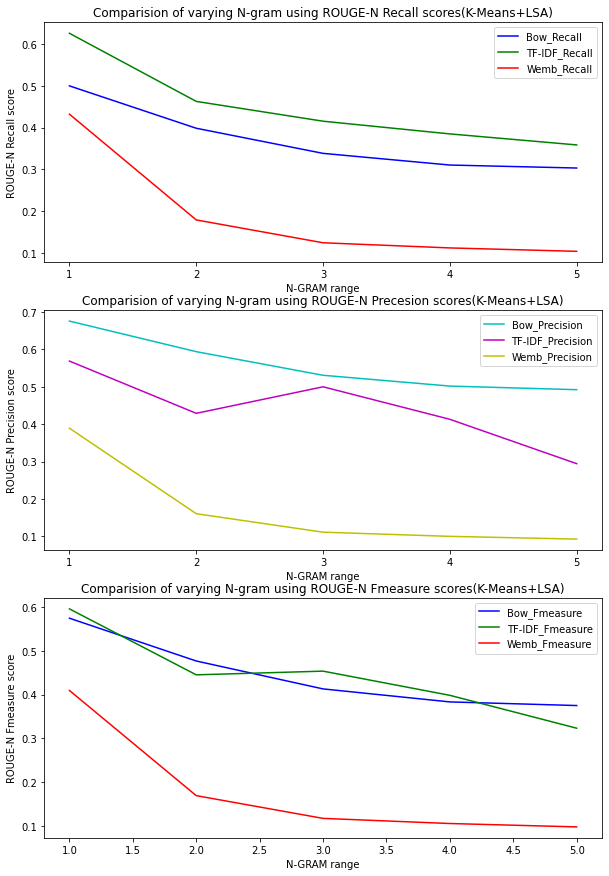

In [152]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,klsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,klsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,klsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(K-Means+LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,klsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,klsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,klsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(K-Means+LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,klsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,klsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,klsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(K-Means+LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

#### LDA

In [153]:
klda_comparision_df = pd.DataFrame()
klda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]


klda_comparision_df["BOW_Recall"] = [bow_lda_kmeans_1gram_rouge.recall,
                                     bow_lda_kmeans_2gram_rouge.recall, 
                                     bow_lda_kmeans_3gram_rouge.recall, 
                                     bow_lda_kmeans_4gram_rouge.recall, 
                                     bow_lda_kmeans_5gram_rouge.recall]

klda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_kmeans_1gram_rouge.recall, 
                                        tfidf_lda_kmeans_2gram_rouge.recall, 
                                        tfidf_lda_kmeans_3gram_rouge.recall, 
                                        tfidf_lda_kmeans_4gram_rouge.recall, 
                                        tfidf_lda_kmeans_5gram_rouge.recall]

klda_comparision_df["W-Emb_Recall"] = [wemb_lda_kmeans_1gram_rouge.recall, 
                                       wemb_lda_kmeans_2gram_rouge.recall, 
                                       wemb_lda_kmeans_3gram_rouge.recall, 
                                       wemb_lda_kmeans_4gram_rouge.recall, 
                                       wemb_lda_kmeans_5gram_rouge.recall]




klda_comparision_df["BOW_Precision"] = [bow_lda_kmeans_1gram_rouge.precision, 
                                        bow_lda_kmeans_2gram_rouge.precision, 
                                        bow_lda_kmeans_3gram_rouge.precision, 
                                        bow_lda_kmeans_4gram_rouge.precision, 
                                        bow_lda_kmeans_5gram_rouge.precision]

klda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_kmeans_1gram_rouge.precision, 
                                           tfidf_lda_kmeans_2gram_rouge.precision, 
                                           tfidf_lda_kmeans_3gram_rouge.precision, 
                                           tfidf_lda_kmeans_4gram_rouge.precision, 
                                           tfidf_lda_kmeans_5gram_rouge.precision]

klda_comparision_df["W-Emb_Precision"] = [wemb_lda_kmeans_1gram_rouge.precision, 
                                          wemb_lda_kmeans_2gram_rouge.precision, 
                                          wemb_lda_kmeans_3gram_rouge.precision, 
                                          wemb_lda_kmeans_4gram_rouge.precision, 
                                          wemb_lda_kmeans_5gram_rouge.precision]




klda_comparision_df["BOW_Fmeasure"] = [bow_lda_kmeans_1gram_rouge.fmeasure, 
                                       bow_lda_kmeans_2gram_rouge.fmeasure, 
                                       bow_lda_kmeans_3gram_rouge.fmeasure, 
                                       bow_lda_kmeans_4gram_rouge.fmeasure, 
                                       bow_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_kmeans_1gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_2gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_3gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_4gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_kmeans_1gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_2gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_3gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_4gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.604651,0.554348,0.361217,0.496183,0.583969,0.362595,0.545073,0.568773,0.361905
1,2-Gram,0.442982,0.297297,0.156489,0.386973,0.295019,0.157088,0.413088,0.296154,0.156788
2,3-Gram,0.107759,0.233333,0.111111,0.096154,0.215385,0.111538,0.101626,0.224000,0.111324
3,4-Gram,0.339535,0.318182,0.100000,0.281853,0.297297,0.100386,0.308017,0.307385,0.100193
4,5-Gram,0.144860,0.144860,0.092664,0.120155,0.120155,0.093023,0.131356,0.131356,0.092843


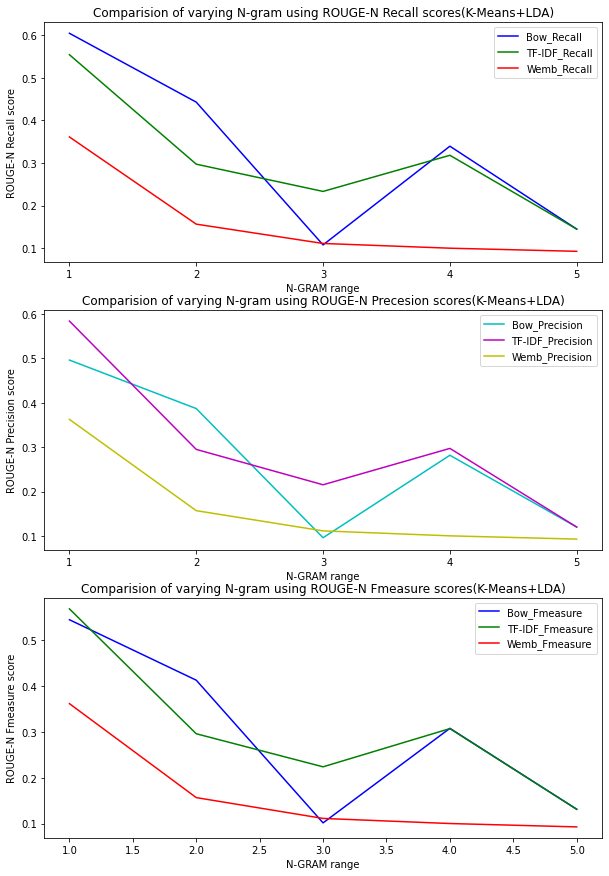

In [154]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,klda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,klda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,klda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(K-Means+LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,klda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,klda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,klda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(K-Means+LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,klda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,klda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,klda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(K-Means+LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

## Overall F Measure Comparision

In [155]:
fm_comparision_df = pd.DataFrame()
fm_comparision_df["LSA_TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
fm_comparision_df["LDA_BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]
fm_comparision_df["LSA_KM_TF-IDF_Fmeasure"] = [tfidf_lsa_kmeans_1gram_rouge.fmeasure, tfidf_lsa_kmeans_2gram_rouge.fmeasure, tfidf_lsa_kmeans_3gram_rouge.fmeasure, tfidf_lsa_kmeans_4gram_rouge.fmeasure, tfidf_lsa_kmeans_5gram_rouge.fmeasure]
fm_comparision_df["LDA_KM_BOW_Fmeasure"] = [bow_lda_kmeans_1gram_rouge.fmeasure, bow_lda_kmeans_2gram_rouge.fmeasure, bow_lda_kmeans_3gram_rouge.fmeasure, bow_lda_kmeans_4gram_rouge.fmeasure, bow_lda_kmeans_5gram_rouge.fmeasure]
fm_comparision_df

,LSA_TF-IDF_Fmeasure,LDA_BOW_Fmeasure,LSA_KM_TF-IDF_Fmeasure,LDA_KM_BOW_Fmeasure
0,0.623274,0.619048,0.596000,0.545073
1,0.292335,0.346749,0.445328,0.413088
2,0.559441,0.550544,0.453752,0.101626
3,0.537594,0.330218,0.398510,0.308017
4,0.208494,0.407240,0.323404,0.131356


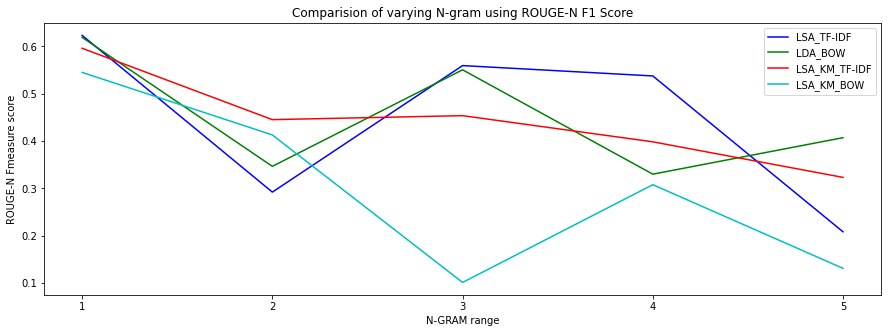

In [156]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

n_gram_range = [i for i in range(1,6)]
ax.plot(n_gram_range,fm_comparision_df["LSA_TF-IDF_Fmeasure"],'b-', label="LSA_TF-IDF")
ax.plot(n_gram_range,fm_comparision_df["LDA_BOW_Fmeasure"],'g-', label="LDA_BOW")
ax.plot(n_gram_range,fm_comparision_df["LSA_KM_TF-IDF_Fmeasure"],'r-', label="LSA_KM_TF-IDF")
ax.plot(n_gram_range,fm_comparision_df["LDA_KM_BOW_Fmeasure"],'c-', label="LSA_KM_BOW")

ax.title.set_text("Comparision of varying N-gram using ROUGE-N F1 Score")
ax.set_xlabel("N-GRAM range")
ax.set_xticks(n_gram_range)
ax.set_ylabel("ROUGE-N Fmeasure score")
ax.legend(loc="best")

plt.show()